## Test: Determine Lambda empirically

In [3]:
# General
import glob
import re
import os.path
import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import pandas as pd
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit

# Statistics
from sklearn.linear_model import LinearRegression
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [4]:
PRMS = {
    'n':              5, # R+ is defined as omega(R+) = n * f
    'sav_fgs':        True,
}

PTHS = {
    'dsg_pth':         '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc',
    'sar_dir':         '/home/arthur/data/cyclobs/centered_rotated_files_31012022/',
    'sct_dir':         '/home/arthur/data/scatterometer/KNMI/product_JF_rotated_filtered_v3/POLAR/2020/EP182020/',
    'sav_dir':         '/home/arthur/results/TCsLifeMonitFromObs/PRJCT_TIME_EVOLUTION/zTest_Determine_Lambda/'
}

### 1) FUNCTIONS

In [50]:
rs = np.linspace(10, 900000, 90000)
dr = 10 # meters

# rs = np.linspace(10000, 900000, 90)
# dr = 10000 # meters

def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def vorticity(r, v):
    '''Relative vorticity'''
    return (1 / r) * np.gradient(r * v, dr)

def v_k10(v0, t, alpha=1., lbda=None):
    # Initial
    v          = np.zeros_like(v0.rad)                             # Raw v0
    v_prop_in  = v0.interp({'rad': v0.rad * np.exp(alpha * t)})    # Inner-core: v0 interpolated on r * e^t
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=RuntimeWarning)
        nr_term    = np.sqrt(1 + 2 * (np.log(v0.rad) + alpha * t)) # Near-core (1)
    v_prop_nr  = v0.interp({'rad': nr_term})                       # Near-core (2)
    ou_term    = np.sqrt(v0.rad ** 2 + 2 * alpha * t)              # Outer-core (1)
    v_prop_ou  = v0.interp({'rad': ou_term})                       # Outer-core (2)
    
    # No friction
    if lbda is None:
        vin        = v_prop_in * np.exp(alpha * t) + v0.rad * (np.exp(2 * alpha * t) - 1) / (2 * alpha)                                     # Inner-core
        vnr        = nr_term * v_prop_nr / v0.rad + (1 - v0.rad ** 2) / (2 * alpha * v0.rad) + np.log(v0.rad) / v0.rad + alpha * t / v0.rad # Near-core
        vou        = ou_term * v_prop_ou / v0.rad + alpha * t / v0.rad                                                                      # Outer-core
        
    # Friction
    else:
        vin        = v_prop_in * np.exp((alpha - lbda) * t) + alpha * v0.rad * (1 - np.exp((2 * alpha - lbda) * t)) / (lbda - 2 * alpha)                                # Inner-core
        vnr        = nr_term * v_prop_nr * np.exp(-lbda * t) / v0.rad + alpha * (lbda * v0.rad ** 2 - 2 * alpha * v0.rad ** (lbda / alpha)) / (lbda * v0.rad * (lbda - 2 * alpha)) - alpha * np.exp(-lbda * t) / (lbda * v0.rad)
        vou        = ou_term * v_prop_ou * np.exp(-lbda * t) / v0.rad + alpha * (1 - np.exp(-lbda * t)) / (lbda * v0.rad) # Outer-core

    # Declare final output
    bd              = np.exp(-alpha * t)
    v[v0.rad < bd]  = vin[v0.rad < bd]
    v[v0.rad >= bd] = vnr[v0.rad >= bd]
    v[v0.rad >= 1]  = vou[v0.rad >= 1]
    
    return v

def compute_RV_plus(r, V, fcor, n=5):
    # Compute R+
    rm       = r[np.nanargmax(V)]
    out      = r > rm          # To find outer-core
    r        = r[out]
    V        = V[out]
    vrt      = vorticity(r, V) # Relative vorticity
    vrt_plan = fcor            # Planetary vorticity

    try: 
        R_plus = r[abs(vrt - n * vrt_plan) < 1e-6][0] # R+
        V_plus = V[r >= R_plus][0]
    except IndexError:
        print('Error: R+ non defined.')
        R_plus = V_plus = np.nan
    
    return R_plus, V_plus

def holland_profile(r, lat, pn, pc, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor  = abs(coriolis(lat))
    rho   = 1.15
    B     = ((Vmax - Vmin) ** 2) * rho * np.e / (pn - pc)
    A     = Rmax ** B
    
    r     = r.astype(float) + 0.001 # To avoid dividing by zero
    V     = r * 0.
    V     = Vmin + np.sqrt(A * B * (pn - pc) * np.exp((-1) * A / (r ** B)) / (rho * r ** B) + (r ** 2 * fcor ** 2) / 4) - (r * fcor / 2)
    return V

def BL_height(r, a):
    '''a is the slope of the BL height'''
    return a * r

# def BL_height(r, a, Rp):
#     return a * (1 - np.exp(-(r / Rp) ** 0.1))

# def BL_height(r, a, Rp):
#     return (2 * a / np.pi) * np.arctan((r / Rp))

def u(r, alpha, fcor_ini, Rp_ini):
    u    = np.zeros_like(r) 
    u_in = -alpha * fcor_ini * r
    u_ou = -alpha * fcor_ini * (Rp_ini ** 2) / r
    u[r <= Rp_ini] = u_in[r <= Rp_ini]
    u[r >= Rp_ini] = u_ou[r >= Rp_ini]
    return u # dimensional

# def propagate(r, a, alpha, V_ini, fcor_ini, dt=1, fitting_mode=False, Cd_plus=2.5e-3):
#     # Compute R+, V+
#     R_plus, V_plus = compute_RV_plus(r, V_ini, fcor_ini, PRMS['n'])
#     # print('R+ = {:.0f}, V+ = {:.1f}'.format(R_plus, V_plus))
    
#     # Compute BL height 
#     h              = BL_height(r, a / 1000)
#     # h                = a * np.ones_like(r)
#     # h              = BL_height(r, a, R_plus)
    
#     # Compute lambda
#     # M_abs          = r * V_ini + 0.5 * fcor_ini * (r ** 2)
#     M_rel          = r * V_ini
#     lbda           = float(Cd_plus * R_plus * (V_plus ** 2)) / (h * M_rel) # dimensional
#     # lbda           = float(Cd_plus * R_plus * (V_plus ** 2)) / (h * M_rel) - (fcor_ini * r * u(r, alpha, fcor_ini, R_plus) / M_rel) # dimensional
#     lbda           = lbda / fcor_ini                                       # non-dimensional
    
#     # plt.plot(r / 1000, 1e6 / r ** 2, c='k')
#     # plt.plot(r / 1000, lbda);plt.yscale('log');plt.xlim(0, 300);plt.show()
    
#     # Normalize
#     V_nrm = xr.DataArray(
#         data=V_ini / (fcor_ini * R_plus),
#         coords={'rad': r / R_plus}
#     )
    
#     # Apply KK10
#     V = v_k10(V_nrm, dt, alpha, lbda=lbda) * fcor_ini * R_plus             # dimensional
    
#     # # Option 1: Fit the whole curve
#     # # In fitting mode, match values of nan with values of initial profile so that it doesn't count
#     # if fitting_mode:
#     #     V[np.isnan(V)] = V_ini[np.isnan(V)]
    
#     # Option 2: Fit Vmax
#     if fitting_mode:
#         V = np.nanmax(V)

#     return V

### 2) SAR DATA

In [6]:
dsg  = xr.open_dataset(PTHS['dsg_pth'])

### FILTER
dsg = dsg.where(dsg.distance_to_coast > dsg.R17_1D * 1000, drop=True)
dsg = dsg.where(abs(dsg.lat_center) < 30, drop=True)
dsg = dsg.where(dsg.B_hol > 0.1, drop=True)
dsg = dsg.where(dsg.Vmax_1D > 25, drop=True)
print('Nb of storms: {}'.format(len(dsg.time)))

print('SAR Mean Rmax = {:.0f} km'.format(dsg.Rmax_1D.mean()))
print('SAR Mean R64  = {:.0f} km'.format(dsg.R33_1D.mean()))

# Manually add Goni because its R17 is nan (I don't know why)
goni      = xr.open_dataset('/home/arthur/data/cyclobs/SAR_compilations_in_nc/Goni_sample.nc')
goni['storm_id'] = np.array('wp222020')
dsg       = xr.concat((dsg, goni), dim='time')

# Select IDs where there are at least 2 SAR images
ids, cts  = np.unique(dsg.storm_id, return_counts=True)
valid_ids = ids[cts > 1]
valid_cts = cts[cts > 1]

print('Mean latitude = {:.1f}°'.format(abs(dsg.lat_center).mean()))
print('Mean Coriolis = {:.1e}'.format(float(coriolis(abs(dsg.lat_center).mean()))))

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/lib-dynload/../../libffi.so.8: version `LIBFFI_CLOSURE_7.0' not found (required by /home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/_cffi_backend.cpython-38-x86_64-linux-gnu.so)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


Nb of storms: 161
SAR Mean Rmax = 31 km
SAR Mean R64  = 57 km
Mean latitude = 18.9°
Mean Coriolis = 4.7e-05


### 3) Determine lambda

In [8]:
# # Parameters
# time_thresh  = 20

# # id = 3, 10, 15, 20, 25, 30, 35
# # Intensifying: 3, 40

# # Iterate
# for tc_id in tqdm(valid_ids[:14]):
#     # Iterate other all SAR acquisitions of the TC, 2 by 2
#     dsi        = dsg.where(dsg.storm_id == tc_id, drop=True).sortby('time')
#     for idx_ini in range(len(dsi.time) - 1):
#         for idx_fin in range(idx_ini + 1, len(dsi.time)):
#             # print(idx_ini, idx_fin)
#             ds_ini     = dsi.isel(time=idx_ini)
#             ds_fin     = dsi.isel(time=idx_fin)   
#             delta_h    = float((ds_fin.time - ds_ini.time) / np.timedelta64(1, 'h'))
#             # Compute VK10 if delta_h is less than threshold
#             if (delta_h <= time_thresh) & (delta_h > 1):
#                 V_ini      = ds_ini.wind_speed.mean(dim='theta', skipna=True).interp(coords={'rad': rs})
#                 V_fin      = ds_fin.wind_speed.mean(dim='theta', skipna=True).interp(coords={'rad': rs})
#                 Vh_ini     = holland_profile(rs, float(abs(ds_ini.lat_center)), float(ds_ini.pn_hol), float(ds_ini.pc_hol), float(ds_ini.Vmin_hol), float(ds_ini.Rmax_hol), float(ds_ini.Vmax_hol))
#                 Vh_fin     = holland_profile(rs, float(abs(ds_fin.lat_center)), float(ds_fin.pn_hol), float(ds_fin.pc_hol), float(ds_fin.Vmin_hol), float(ds_fin.Rmax_hol), float(ds_fin.Vmax_hol))
#                 fcor_ini   = float(abs(coriolis(ds_ini.lat_center)))
#                 fcor_fin   = float(abs(coriolis(ds_fin.lat_center)))
                
#                 # Compute R+ metrics
#                 Rp_ini, Vp_ini   = compute_RV_plus(rs, Vh_ini,    float(abs(coriolis(ds_ini.lat_center))), PRMS['n'])
                
#                 # dt
#                 tau      = ((1 / fcor_ini) / 3600)
#                 dt       = delta_h / tau
                
#                 # Alpha
#                 alpha = 1

In [48]:
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
import warnings
warnings.filterwarnings("ignore")

def propagate(r, lbda, V_ini, fcor_ini, dt=1, alpha=1, Cd_plus=2.5e-3):
    # Compute R+, V+
    R_plus, V_plus = compute_RV_plus(r, V_ini, fcor_ini, PRMS['n'])
    
    # Normalize
    V_nrm = xr.DataArray(
        data=V_ini / (fcor_ini * R_plus),
        coords={'rad': r / R_plus}
    )
    # lbda = lbda / fcor_ini                                   # non-dimensional
    
    # Apply KK10
    V = v_k10(V_nrm, dt, alpha, lbda=lbda) * fcor_ini * R_plus # dimensional

    return V

def local_loss(lbda, i, V_ini, V_fin, dt, alpha):
    V_mod = propagate(rs, lbda, V_ini, fcor_ini, dt=dt, alpha=alpha)
    # print(lbda)
    # print(lbda, V_ini[i], V_mod[i])
    return np.sqrt((V_fin[i] - V_mod[i]) ** 2)

In [110]:
# Parameters
time_thresh  = 20
lbda0        = 0.7
alpha        = 1

# Iterate
for tc_id in tqdm(valid_ids):
    # Iterate other all SAR acquisitions of the TC, 2 by 2
    dsi        = dsg.where(dsg.storm_id == tc_id, drop=True).sortby('time')
    try:
        tc_id = tc_id.item()
    except AttributeError:
        tc_id
    for idx_ini in range(len(dsi.time) - 1):
        for idx_fin in range(idx_ini + 1, len(dsi.time)):
            # print(idx_ini, idx_fin)
            ds_ini     = dsi.isel(time=idx_ini)
            ds_fin     = dsi.isel(time=idx_fin)   
            delta_h    = float((ds_fin.time - ds_ini.time) / np.timedelta64(1, 'h'))
            # Compute VK10 if delta_h is less than threshold
            if (delta_h <= time_thresh) & (delta_h > 1):
                V_ini      = ds_ini.wind_speed.mean(dim='theta', skipna=True).interp(coords={'rad': rs})
                V_fin      = ds_fin.wind_speed.mean(dim='theta', skipna=True).interp(coords={'rad': rs})
                Vh_ini     = holland_profile(rs, float(abs(ds_ini.lat_center)), float(ds_ini.pn_hol), float(ds_ini.pc_hol), float(ds_ini.Vmin_hol), float(ds_ini.Rmax_hol), float(ds_ini.Vmax_hol))
                Vh_fin     = holland_profile(rs, float(abs(ds_fin.lat_center)), float(ds_fin.pn_hol), float(ds_fin.pc_hol), float(ds_fin.Vmin_hol), float(ds_fin.Rmax_hol), float(ds_fin.Vmax_hol))
                fcor_ini   = float(abs(coriolis(ds_ini.lat_center)))
                fcor_fin   = float(abs(coriolis(ds_fin.lat_center)))
                
                # Compute R+ metrics
                Rp_ini, Vp_ini   = compute_RV_plus(rs, Vh_ini, float(abs(coriolis(ds_ini.lat_center))), PRMS['n'])
                
                # dt
                tau      = ((1 / fcor_ini) / 3600)
                dt       = delta_h / tau
                
                # Plot profiles
                plt.plot(rs / 1000, Vh_ini, c='k', label='SAR ini', linewidth=3)
                plt.plot(rs / 1000, Vh_fin, c='orangered', label='SAR fin', linewidth=3)
                plt.xlim(0, 300)
                plt.grid();plt.legend()
                if PRMS['sav_fgs']:
                    plt.savefig(PTHS['sav_dir'] + '{}_idx_ini{}_idx_fin{}_profiles'.format(tc_id, idx_ini, idx_fin))
                plt.clf()
                
                # Determine lambda - coarse
                LBDAS = []
                IS    = []
                for i in tqdm(rs[999::1000][:10]):
                    i     = int(i / 10)
                    opt   = minimize_scalar(local_loss, args=(i, Vh_ini, Vh_fin, dt, alpha), tol=1e-5)
                    V     = propagate(rs, opt.x, Vh_ini, fcor_ini, dt=dt, alpha=alpha)
                    if abs(Vh_fin[i] - V[i]) > 1:
                        print('ERROR')
                        # print('FINAL LBDA = {}'.format(opt.x))
                        print(i, Vh_fin[i], V[i])
                    # Append
                    LBDAS.append(opt.x)
                    IS.append(i)
                plt.scatter(rs[IS] / 1000, LBDAS, c='tab:blue')
                
                # Determine lambda - fine
                LBDAS = []
                IS    = []
                for i in tqdm(rs[::100][:10]):
                    i     = int(i / 10)
                    opt   = minimize_scalar(local_loss, args=(i, Vh_ini, Vh_fin, dt, alpha), tol=1e-5)
                    V     = propagate(rs, opt.x, Vh_ini, fcor_ini, dt=dt, alpha=alpha)
                    if abs(Vh_fin[i] - V[i]) > 1:
                        print('ERROR')
                        print(i, Vh_fin[i], V[i])
                    # Append
                    LBDAS.append(opt.x)
                    IS.append(i)
                plt.scatter(rs[IS] / 1000, LBDAS, c='tab:blue')
                
                # Plot lambda
                plt.plot(rs / 1000, 0.06 * Rp_ini ** 2 / (rs ** 2), c='r', label='0.06 * R+^2 / r^2')
                plt.plot(rs / 1000, 0.2 * (Rp_ini / rs) ** 1, c='g', label='0.2 * R+ / r')
                plt.plot(rs / 1000, 0.02 * (Rp_ini ** 2 * Vp_ini / (rs ** 2 * Vh_ini)), c='gray', label='0.02 * R+^2 * V+ / (r^2 * v)')
                plt.xlim(-1, 100)
                plt.ylim(0, 2)
                plt.grid();plt.legend()
                if PRMS['sav_fgs']:
                    plt.savefig(PTHS['sav_dir'] + '{}_idx_ini{}_idx_fin{}_lambdas'.format(tc_id, idx_ini, idx_fin))
                plt.clf()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

<Figure size 1500x1000 with 0 Axes>

### Alpha = 0.5

In [112]:
# Parameters
time_thresh     = 20
lbda0           = 0.7
alpha           = 0.5
# lbda_candidates = np.linspace(0.01, 3, 20)
lbda_candidates = np.concatenate(([0.00001, 0.0001, 0.0005, 0.001, 0.003, 0.006, 0.01], np.linspace(0.05, 2, 20))) # alpha = 0.5
# lbda_candidates = np.linspace(0.1, 15, 30)

# Iterate
for tc_id in tqdm(valid_ids):
    # Iterate other all SAR acquisitions of the TC, 2 by 2
    dsi        = dsg.where(dsg.storm_id == tc_id, drop=True).sortby('time')
    try:
        tc_id = tc_id.item()
    except AttributeError:
        tc_id
    for idx_ini in range(len(dsi.time) - 1):
        for idx_fin in range(idx_ini + 1, len(dsi.time)):
            # print(idx_ini, idx_fin)
            ds_ini     = dsi.isel(time=idx_ini)
            ds_fin     = dsi.isel(time=idx_fin)   
            delta_h    = float((ds_fin.time - ds_ini.time) / np.timedelta64(1, 'h'))
            # Compute VK10 if delta_h is less than threshold
            if (delta_h <= time_thresh) & (delta_h > 1):
                V_ini      = ds_ini.wind_speed.mean(dim='theta', skipna=True).interp(coords={'rad': rs})
                V_fin      = ds_fin.wind_speed.mean(dim='theta', skipna=True).interp(coords={'rad': rs})
                Vh_ini     = holland_profile(rs, float(abs(ds_ini.lat_center)), float(ds_ini.pn_hol), float(ds_ini.pc_hol), float(ds_ini.Vmin_hol), float(ds_ini.Rmax_hol), float(ds_ini.Vmax_hol))
                Vh_fin     = holland_profile(rs, float(abs(ds_fin.lat_center)), float(ds_fin.pn_hol), float(ds_fin.pc_hol), float(ds_fin.Vmin_hol), float(ds_fin.Rmax_hol), float(ds_fin.Vmax_hol))
                fcor_ini   = float(abs(coriolis(ds_ini.lat_center)))
                fcor_fin   = float(abs(coriolis(ds_fin.lat_center)))
                
                # Compute R+ metrics
                Rp_ini, Vp_ini   = compute_RV_plus(rs, Vh_ini, float(abs(coriolis(ds_ini.lat_center))), PRMS['n'])
                
                # dt
                tau      = ((1 / fcor_ini) / 3600)
                dt       = delta_h / tau
                
                # Plot profiles
                plt.plot(rs / 1000, Vh_ini, c='k', label='SAR ini', linewidth=3)
                plt.plot(rs / 1000, Vh_fin, c='orangered', label='SAR fin', linewidth=3)
                plt.xlim(0, 300)
                plt.grid();plt.legend()
                if PRMS['sav_fgs']:
                    plt.savefig(PTHS['sav_dir'] + '{}_idx_ini{}_idx_fin{}_profiles'.format(tc_id, idx_ini, idx_fin))
                plt.clf()
                
                # Determine lambda - coarse
                LBDAS = []
                IS    = []
                for i in tqdm(rs[999::1000][:10]):
                    i     = int(i / 10)
                    
                    losses = []
                    for l in lbda_candidates:
                        lss = local_loss(l, i, Vh_ini, Vh_fin, dt, alpha)
                        losses.append(lss)
                    res = lbda_candidates[np.nanargmin(losses)]
                    
                    V     = propagate(rs, res, Vh_ini, fcor_ini, dt=dt, alpha=alpha)
                    if abs(Vh_fin[i] - V[i]) > 3:
                        print('ERROR')
                        print('FINAL LBDA = {}'.format(res))
                        print(i, Vh_fin[i], V[i])
                    # Append
                    LBDAS.append(res)
                    IS.append(i)
                plt.scatter(rs[IS] / 1000, LBDAS, c='tab:blue')
                
                # Determine lambda - fine
                LBDAS = []
                IS    = []
                for i in tqdm(rs[::100][:10]):
                    i     = int(i / 10)
                    
                    losses = []
                    for l in lbda_candidates:
                        lss = local_loss(l, i, Vh_ini, Vh_fin, dt, alpha)
                        losses.append(lss)
                    res = lbda_candidates[np.nanargmin(losses)]
                    
                    V     = propagate(rs, res, Vh_ini, fcor_ini, dt=dt, alpha=alpha)
                    if abs(Vh_fin[i] - V[i]) > 3:
                        print('ERROR')
                        print('FINAL LBDA = {}'.format(res))
                        print(i, Vh_fin[i], V[i])
                    # Append
                    LBDAS.append(res)
                    IS.append(i)
                plt.scatter(rs[IS] / 1000, LBDAS, c='tab:blue')
                
                # Plot lambda
                plt.plot(rs / 1000, 0.06 * Rp_ini ** 2 / (rs ** 2), c='r', label='0.06 * R+^2 / r^2')
                plt.plot(rs / 1000, 0.2 * (Rp_ini / rs) ** 1, c='g', label='0.2 * R+ / r')
                plt.plot(rs / 1000, 0.02 * (Rp_ini ** 2 * Vp_ini / (rs ** 2 * Vh_ini)), c='gray', label='0.02 * R+^2 * V+ / (r^2 * v)')
                plt.xlim(-1, 100)
                plt.ylim(0, 2)
                plt.grid();plt.legend()
                if PRMS['sav_fgs']:
                    plt.savefig(PTHS['sav_dir'] + '{}_idx_ini{}_idx_fin{}_lambdas'.format(tc_id, idx_ini, idx_fin))
                plt.clf()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

ERROR
FINAL LBDA = 0.4605263157894737
601 54.400941641453635 51.31978282005281
ERROR
FINAL LBDA = 0.25526315789473686
801 60.34773292170516 65.18072023565408


  0%|          | 0/10 [00:00<?, ?it/s]

ERROR
FINAL LBDA = 0.25526315789473686
1000 62.61313198064398 58.55224271052513


  0%|          | 0/10 [00:00<?, ?it/s]

ERROR
FINAL LBDA = 0.25526315789473686
701 66.81552809865028 72.48668635895952


<Figure size 1500x1000 with 0 Axes>

### Alpha = 10

In [113]:
# Parameters
time_thresh     = 20
lbda0           = 0.7
alpha           = 10
lbda_candidates = np.linspace(0.1, 15, 30)

# Iterate
for tc_id in tqdm(valid_ids[35:]):
    # Iterate other all SAR acquisitions of the TC, 2 by 2
    dsi        = dsg.where(dsg.storm_id == tc_id, drop=True).sortby('time')
    try:
        tc_id = tc_id.item()
    except AttributeError:
        tc_id
    for idx_ini in range(len(dsi.time) - 1):
        for idx_fin in range(idx_ini + 1, len(dsi.time)):
            # print(idx_ini, idx_fin)
            ds_ini     = dsi.isel(time=idx_ini)
            ds_fin     = dsi.isel(time=idx_fin)   
            delta_h    = float((ds_fin.time - ds_ini.time) / np.timedelta64(1, 'h'))
            # Compute VK10 if delta_h is less than threshold
            if (delta_h <= time_thresh) & (delta_h > 1):
                V_ini      = ds_ini.wind_speed.mean(dim='theta', skipna=True).interp(coords={'rad': rs})
                V_fin      = ds_fin.wind_speed.mean(dim='theta', skipna=True).interp(coords={'rad': rs})
                Vh_ini     = holland_profile(rs, float(abs(ds_ini.lat_center)), float(ds_ini.pn_hol), float(ds_ini.pc_hol), float(ds_ini.Vmin_hol), float(ds_ini.Rmax_hol), float(ds_ini.Vmax_hol))
                Vh_fin     = holland_profile(rs, float(abs(ds_fin.lat_center)), float(ds_fin.pn_hol), float(ds_fin.pc_hol), float(ds_fin.Vmin_hol), float(ds_fin.Rmax_hol), float(ds_fin.Vmax_hol))
                fcor_ini   = float(abs(coriolis(ds_ini.lat_center)))
                fcor_fin   = float(abs(coriolis(ds_fin.lat_center)))
                
                # Compute R+ metrics
                Rp_ini, Vp_ini   = compute_RV_plus(rs, Vh_ini, float(abs(coriolis(ds_ini.lat_center))), PRMS['n'])
                
                # dt
                tau      = ((1 / fcor_ini) / 3600)
                dt       = delta_h / tau
                
                # Plot profiles
                plt.plot(rs / 1000, Vh_ini, c='k', label='SAR ini', linewidth=3)
                plt.plot(rs / 1000, Vh_fin, c='orangered', label='SAR fin', linewidth=3)
                plt.xlim(0, 300)
                plt.grid();plt.legend()
                if PRMS['sav_fgs']:
                    plt.savefig(PTHS['sav_dir'] + '{}_idx_ini{}_idx_fin{}_profiles'.format(tc_id, idx_ini, idx_fin))
                plt.clf()
                
                # Determine lambda - coarse
                LBDAS = []
                IS    = []
                for i in tqdm(rs[999::1000][:10]):
                    i     = int(i / 10)
                    
                    losses = []
                    for l in lbda_candidates:
                        lss = local_loss(l, i, Vh_ini, Vh_fin, dt, alpha)
                        losses.append(lss)
                    res = lbda_candidates[np.nanargmin(losses)]
                    
                    V     = propagate(rs, res, Vh_ini, fcor_ini, dt=dt, alpha=alpha)
                    if abs(Vh_fin[i] - V[i]) > 3:
                        print('ERROR')
                        print('FINAL LBDA = {}'.format(res))
                        print(i, Vh_fin[i], V[i])
                    # Append
                    LBDAS.append(res)
                    IS.append(i)
                plt.scatter(rs[IS] / 1000, LBDAS, c='tab:blue')
                
                # Determine lambda - fine
                LBDAS = []
                IS    = []
                for i in tqdm(rs[::100][:10]):
                    i     = int(i / 10)
                    
                    losses = []
                    for l in lbda_candidates:
                        lss = local_loss(l, i, Vh_ini, Vh_fin, dt, alpha)
                        losses.append(lss)
                    res = lbda_candidates[np.nanargmin(losses)]
                    
                    V     = propagate(rs, res, Vh_ini, fcor_ini, dt=dt, alpha=alpha)
                    if abs(Vh_fin[i] - V[i]) > 3:
                        print('ERROR')
                        print('FINAL LBDA = {}'.format(res))
                        print(i, Vh_fin[i], V[i])
                    # Append
                    LBDAS.append(res)
                    IS.append(i)
                plt.scatter(rs[IS] / 1000, LBDAS, c='tab:blue')
                
                # Plot lambda
                plt.plot(rs / 1000,  0.5 * Rp_ini ** 2 / (rs ** 2), c='r', label='0.5 R+^2 / r^2')
                plt.plot(rs / 1000, (Rp_ini / rs) ** 1, c='g', label='R+ / r')
                plt.plot(rs / 1000, 0.5 * (Rp_ini ** 2 * Vp_ini / (rs ** 2 * Vh_ini)), c='gray', label='0.5 R+^2 * V+ / (r^2 * v)')
                plt.xlim(-1, 100)
                plt.ylim(0, 15)
                plt.grid();plt.legend()
                if PRMS['sav_fgs']:
                    plt.savefig(PTHS['sav_dir'] + '{}_idx_ini{}_idx_fin{}_lambdas'.format(tc_id, idx_ini, idx_fin))
                plt.clf()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

ERROR
FINAL LBDA = 1.1275862068965519
2000 42.23245968158694 31.258690255035372
ERROR
FINAL LBDA = 0.6137931034482759
3000 32.55230572355712 39.96423482397989
ERROR
FINAL LBDA = 0.6137931034482759
4000 27.0383057465767 30.101166195339985
ERROR
FINAL LBDA = 0.6137931034482759
10000 15.724412167596569 12.485289681821502


  0%|          | 0/10 [00:00<?, ?it/s]

ERROR
FINAL LBDA = 2.1551724137931036
501 45.47154825943657 40.19034502070564
ERROR
FINAL LBDA = 1.6413793103448278
701 58.83075383145646 47.40038412493778
ERROR
FINAL LBDA = 1.1275862068965519
801 60.34773292170516 72.96748537392673
ERROR
FINAL LBDA = 1.1275862068965519
901 60.15922289335442 65.488220679915


  0%|          | 0/10 [00:00<?, ?it/s]

ERROR
FINAL LBDA = 1.6413793103448278
1000 62.61313198064398 56.932052623376
ERROR
FINAL LBDA = 1.1275862068965519
2000 45.19401640266091 50.76937265980983
ERROR
FINAL LBDA = 1.1275862068965519
4000 30.6660248859093 26.38586440156419
ERROR
FINAL LBDA = 1.1275862068965519
5000 27.174060191342786 21.18169180863043
ERROR
FINAL LBDA = 1.1275862068965519
6000 24.689601838437003 17.69431780890296
ERROR
FINAL LBDA = 0.6137931034482759
7000 22.816637011859655 27.491761050926684


  0%|          | 0/10 [00:00<?, ?it/s]

ERROR
FINAL LBDA = 2.1551724137931036
501 61.40659560012606 65.70732126919594
ERROR
FINAL LBDA = 2.1551724137931036
601 65.76952453229626 56.61299547352605
ERROR
FINAL LBDA = 1.6413793103448278
701 66.81552809865028 77.61014025453062


<Figure size 1500x1000 with 0 Axes>

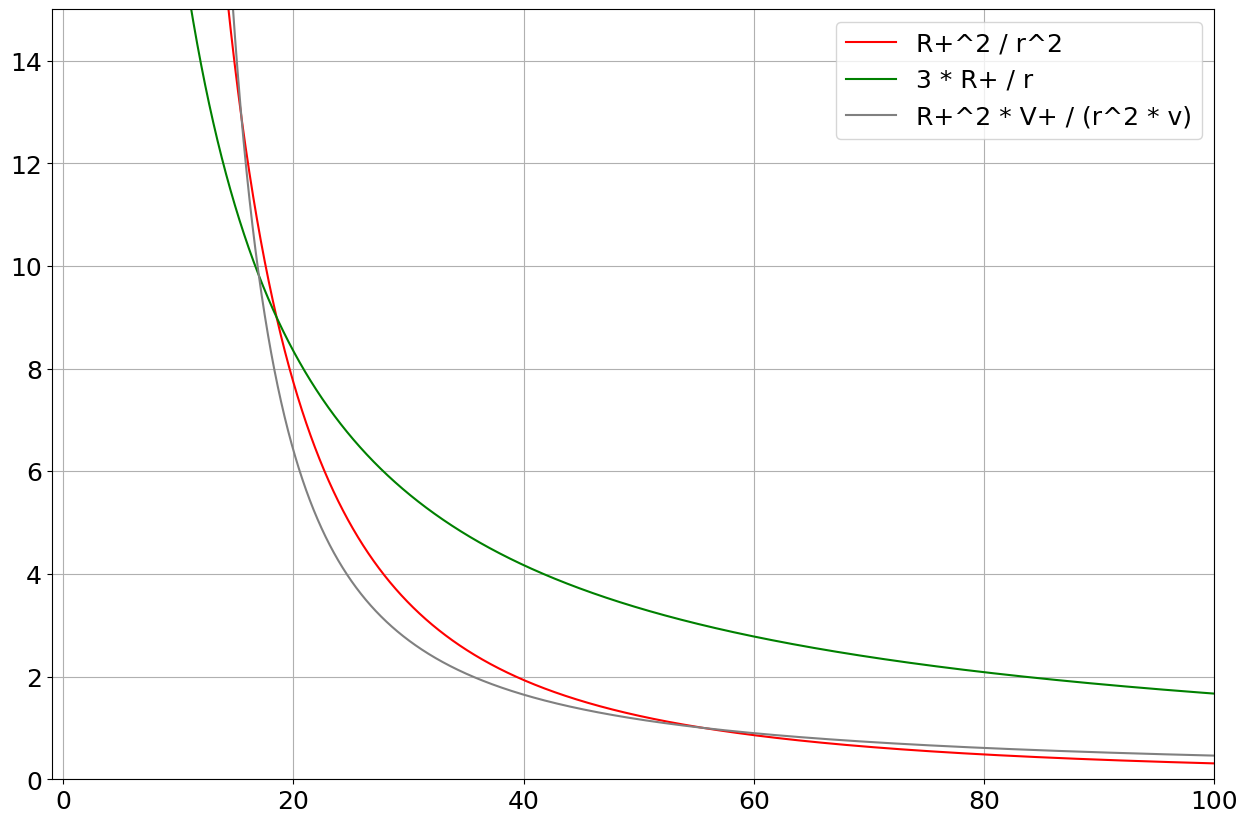

In [90]:
# Plot lambda
plt.plot(rs / 1000,  Rp_ini ** 2 / (rs ** 2), c='r', label='R+^2 / r^2')
plt.plot(rs / 1000,  3 * (Rp_ini / rs) ** 1, c='g', label='3 * R+ / r')
plt.plot(rs / 1000, (Rp_ini ** 2 * Vp_ini / (rs ** 2 * Vh_ini)), c='gray', label='R+^2 * V+ / (r^2 * v)')
plt.xlim(-1, 100)
plt.ylim(0, 15)
plt.grid();plt.legend()

#### Test Goni

In [28]:
# Parameters
time_thresh  = 20
lbda0        = 0.7
alpha        = 1

# Iterate
for tc_id in tqdm(valid_ids[35:36]):
    # Iterate other all SAR acquisitions of the TC, 2 by 2
    dsi        = dsg.where(dsg.storm_id == tc_id, drop=True).sortby('time')
    try:
        tc_id = tc_id.item()
    except AttributeError:
        tc_id
    idx_ini = 0
    idx_fin = 1
    
    ds_ini     = dsi.isel(time=idx_ini)
    ds_fin     = dsi.isel(time=idx_fin)   
    delta_h    = float((ds_fin.time - ds_ini.time) / np.timedelta64(1, 'h'))
    # Compute VK10 if delta_h is less than threshold
    if (delta_h <= time_thresh) & (delta_h > 1):
        V_ini      = ds_ini.wind_speed.mean(dim='theta', skipna=True).interp(coords={'rad': rs})
        V_fin      = ds_fin.wind_speed.mean(dim='theta', skipna=True).interp(coords={'rad': rs})
        Vh_ini     = holland_profile(rs, float(abs(ds_ini.lat_center)), float(ds_ini.pn_hol), float(ds_ini.pc_hol), float(ds_ini.Vmin_hol), float(ds_ini.Rmax_hol), float(ds_ini.Vmax_hol))
        Vh_fin     = holland_profile(rs, float(abs(ds_fin.lat_center)), float(ds_fin.pn_hol), float(ds_fin.pc_hol), float(ds_fin.Vmin_hol), float(ds_fin.Rmax_hol), float(ds_fin.Vmax_hol))
        fcor_ini   = float(abs(coriolis(ds_ini.lat_center)))
        fcor_fin   = float(abs(coriolis(ds_fin.lat_center)))

        # Compute R+ metrics
        Rp_ini, Vp_ini   = compute_RV_plus(rs, Vh_ini, float(abs(coriolis(ds_ini.lat_center))), PRMS['n'])

        # dt
        tau      = ((1 / fcor_ini) / 3600)
        dt       = delta_h / tau

        # Determine lambda - coarse
        LBDAS_COARSE = []
        IS_COARSE    = []
        for i in tqdm(rs[999::1000][:10]):
            i     = int(i / 10)
            opt   = minimize_scalar(local_loss, args=(i, Vh_ini, Vh_fin, dt, alpha), tol=1e-5)
            V     = propagate(rs, opt.x, Vh_ini, fcor_ini, dt=dt, alpha=alpha)
            if abs(Vh_fin[i] - V[i]) > 1:
                print('ERROR')
                # print('FINAL LBDA = {}'.format(opt.x))
                print(i, Vh_fin[i], V[i])
            # Append
            LBDAS_COARSE.append(opt.x)
            IS_COARSE.append(i)

        # Determine lambda - fine
        LBDAS = []
        IS    = []
        for i in tqdm(rs[::100][:10]):
            i     = int(i / 10)
            opt   = minimize_scalar(local_loss, args=(i, Vh_ini, Vh_fin, dt, alpha), tol=1e-5)
            V     = propagate(rs, opt.x, Vh_ini, fcor_ini, dt=dt, alpha=alpha)
            if abs(Vh_fin[i] - V[i]) > 1:
                print('ERROR')
                print(i, Vh_fin[i], V[i])
            # Append
            LBDAS.append(opt.x)
            IS.append(i)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

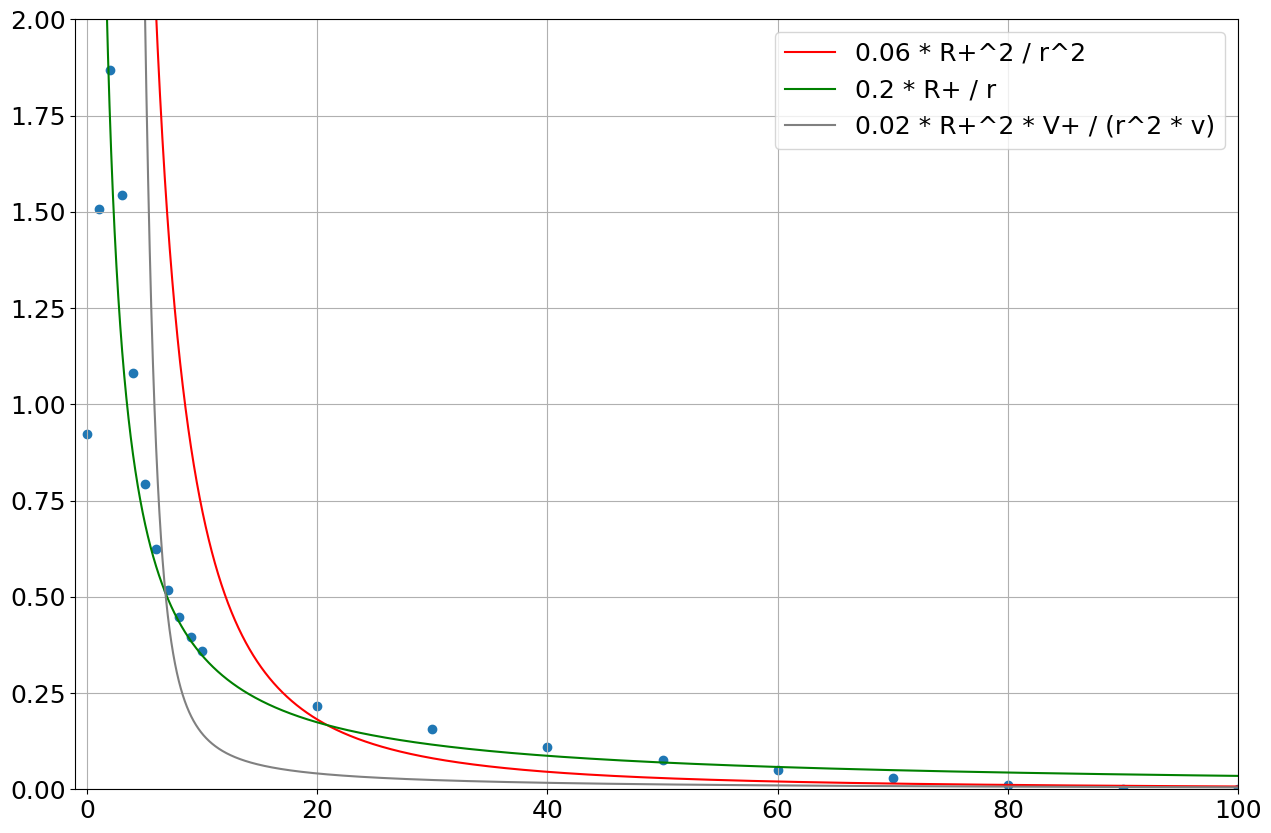

In [42]:
plt.scatter(rs[IS_COARSE] / 1000, LBDAS_COARSE, c='tab:blue')
plt.scatter(rs[IS] / 1000, LBDAS, c='tab:blue')
plt.plot(rs / 1000, 0.06 * Rp_ini ** 2 / (rs ** 2), c='r', label='0.06 * R+^2 / r^2')
plt.plot(rs / 1000, 0.1 * (Rp_ini / rs) ** 1, c='g', label='0.2 * R+ / r')
plt.plot(rs / 1000, 0.02 * (Rp_ini ** 2 * Vp_ini / (rs ** 2 * Vh_ini)), c='gray', label='0.02 * R+^2 * V+ / (r^2 * v)')
plt.xlim(-1, 100)
plt.ylim(0, 2)
plt.grid();plt.legend()

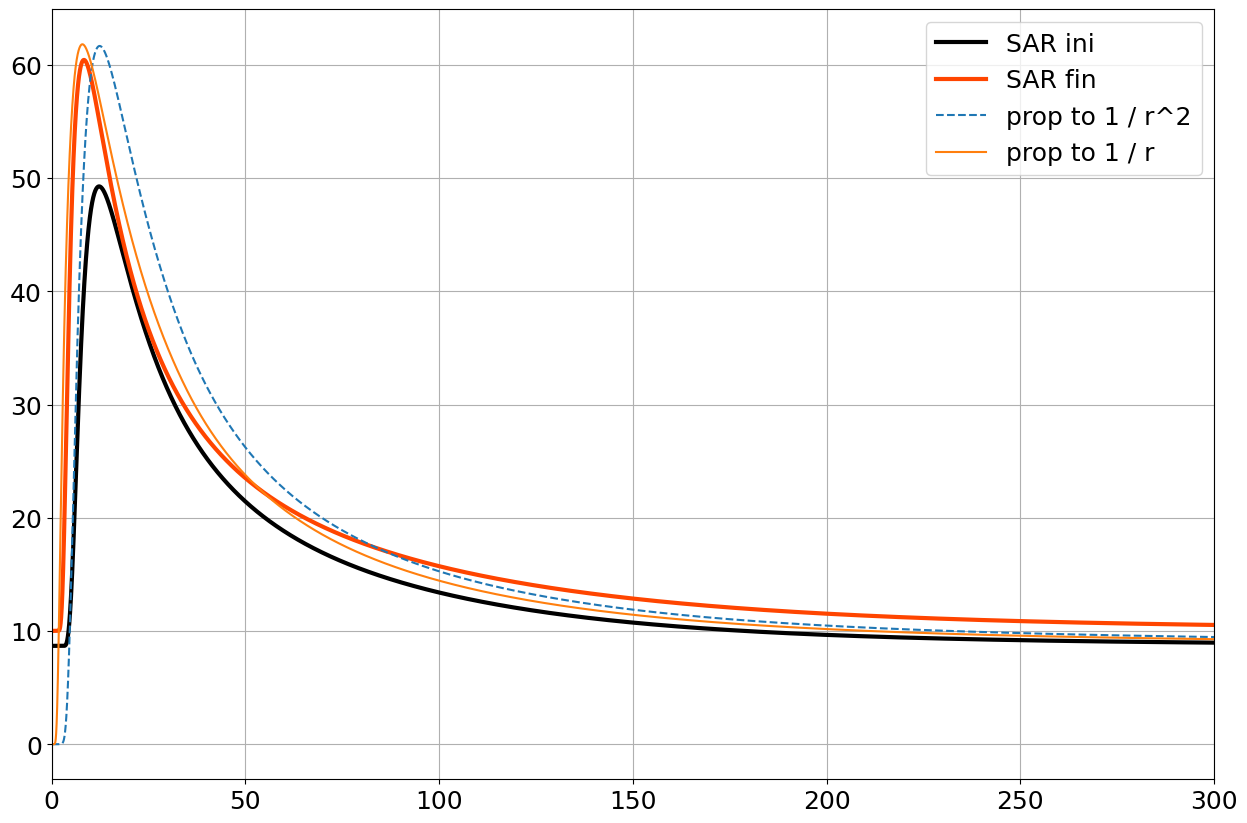

In [107]:
# Plot profiles
plt.plot(rs / 1000, Vh_ini, c='k', label='SAR ini', linewidth=3)
plt.plot(rs / 1000, Vh_fin, c='orangered', label='SAR fin', linewidth=3)

# MODEL
# lbda  = 0.06 * Rp_ini ** 2 / (rs ** 2)
lbda  = 0.03 * (Rp_ini / rs) ** 2
V     = propagate(rs, lbda, Vh_ini, fcor_ini, dt=dt, alpha=alpha)
plt.plot(rs / 1000, V, label='prop to 1 / r^2', linestyle='dashed')

lbda  = 0.1 * (Rp_ini / rs) ** 1
V     = propagate(rs, lbda, Vh_ini, fcor_ini, dt=dt, alpha=alpha)
plt.plot(rs / 1000, V, label='prop to 1 / r')

# Grids
plt.xlim(0, 300)
plt.grid();plt.legend()

In [108]:
# def v_k10(v0, t, alpha=1., lbda=None):
#     # Initial
#     v          = np.zeros_like(v0.copy(deep=True).rad)                             # Raw v0
#     v_prop_in  = v0.copy(deep=True).interp({'rad': v0.copy(deep=True).rad * np.exp(alpha * t)})    # Inner-core: v0 interpolated on r * e^t
#     with warnings.catch_warnings():
#         warnings.simplefilter('ignore', category=RuntimeWarning)
#         nr_term    = np.sqrt(1 + 2 * (np.log(v0.copy(deep=True).rad) + alpha * t)) # Near-core (1)
#     v_prop_nr  = v0.copy(deep=True).interp({'rad': nr_term})                       # Near-core (2)
#     ou_term    = np.sqrt(v0.copy(deep=True).rad ** 2 + 2 * alpha * t)              # Outer-core (1)
#     v_prop_ou  = v0.copy(deep=True).interp({'rad': ou_term})                       # Outer-core (2)
    
#     # No friction
#     if lbda is None:
#         vin        = v_prop_in * np.exp(alpha * t) + v0.copy(deep=True).rad * (np.exp(2 * alpha * t) - 1) / (2 * alpha)                                     # Inner-core
#         vnr        = nr_term * v_prop_nr / v0.copy(deep=True).rad + (1 - v0.copy(deep=True).rad ** 2) / (2 * alpha * v0.copy(deep=True).rad) + np.log(v0.copy(deep=True).rad) / v0.copy(deep=True).rad + alpha * t / v0.copy(deep=True).rad # Near-core
#         vou        = ou_term * v_prop_ou / v0.copy(deep=True).rad + alpha * t / v0.copy(deep=True).rad                                                                      # Outer-core
        
#     # Friction
#     else:
#         vin        = v_prop_in * np.exp((alpha - lbda) * t) + alpha * v0.copy(deep=True).rad * (1 - np.exp((2 * alpha - lbda) * t)) / (lbda - 2 * alpha)                                # Inner-core
#         vnr        = nr_term * v_prop_nr * np.exp(-lbda * t) / v0.copy(deep=True).rad + alpha * (lbda * v0.copy(deep=True).rad ** 2 - 2 * alpha * v0.copy(deep=True).rad ** (lbda / alpha)) / (lbda * v0.copy(deep=True).rad * (lbda - 2 * alpha)) - alpha * np.exp(-lbda * t) / (lbda * v0.copy(deep=True).rad)
#         vou        = ou_term * v_prop_ou * np.exp(-lbda * t) / v0.copy(deep=True).rad + alpha * (1 - np.exp(-lbda * t)) / (lbda * v0.copy(deep=True).rad) # Outer-core

#     # Declare final output
#     bd              = np.exp(-alpha * t)
#     v[v0.copy(deep=True).rad < bd]  = vin[v0.copy(deep=True).rad < bd]
#     v[v0.copy(deep=True).rad >= bd] = vnr[v0.copy(deep=True).rad >= bd]
#     v[v0.copy(deep=True).rad >= 1]  = vou[v0.copy(deep=True).rad >= 1]
    
#     return v

# V_nrm = xr.DataArray(
#         data=Vh_ini / (fcor_ini * Rp_ini),
#         coords={'rad': rs / Rp_ini}
#     )

# plt.plot(rs, v_k10(V_nrm, dt, alpha=1., lbda=lbda) * fcor_ini * Rp_ini)

In [118]:
# Parameters
time_thresh     = 20
lbda0           = 0.7
alpha           = 10
lbda_candidates = np.linspace(0.1, 2, 30)

# Iterate
for tc_id in tqdm(valid_ids[35:36]):
    # Iterate other all SAR acquisitions of the TC, 2 by 2
    dsi        = dsg.where(dsg.storm_id == tc_id, drop=True).sortby('time')
    try:
        tc_id = tc_id.item()
    except AttributeError:
        tc_id
    idx_ini = 0
    idx_fin = 1
    
    # print(idx_ini, idx_fin)
    ds_ini     = dsi.isel(time=idx_ini)
    ds_fin     = dsi.isel(time=idx_fin)   
    delta_h    = float((ds_fin.time - ds_ini.time) / np.timedelta64(1, 'h'))
    # Compute VK10 if delta_h is less than threshold
    if (delta_h <= time_thresh) & (delta_h > 1):
        V_ini      = ds_ini.wind_speed.mean(dim='theta', skipna=True).interp(coords={'rad': rs})
        V_fin      = ds_fin.wind_speed.mean(dim='theta', skipna=True).interp(coords={'rad': rs})
        Vh_ini     = holland_profile(rs, float(abs(ds_ini.lat_center)), float(ds_ini.pn_hol), float(ds_ini.pc_hol), float(ds_ini.Vmin_hol), float(ds_ini.Rmax_hol), float(ds_ini.Vmax_hol))
        Vh_fin     = holland_profile(rs, float(abs(ds_fin.lat_center)), float(ds_fin.pn_hol), float(ds_fin.pc_hol), float(ds_fin.Vmin_hol), float(ds_fin.Rmax_hol), float(ds_fin.Vmax_hol))
        fcor_ini   = float(abs(coriolis(ds_ini.lat_center)))
        fcor_fin   = float(abs(coriolis(ds_fin.lat_center)))

        # Compute R+ metrics
        Rp_ini, Vp_ini   = compute_RV_plus(rs, Vh_ini, float(abs(coriolis(ds_ini.lat_center))), PRMS['n'])

        # dt
        tau      = ((1 / fcor_ini) / 3600)
        dt       = delta_h / tau

        # Determine lambda - coarse
        LBDAS_COARSE = []
        IS_COARSE    = []
        for i in tqdm(rs[999::1000][:20]):
            i     = int(i / 10)

            losses = []
            for l in lbda_candidates:
                lss = local_loss(l, i, Vh_ini, Vh_fin, dt, alpha)
                losses.append(lss)
            res = lbda_candidates[np.nanargmin(losses)]

            V     = propagate(rs, res, Vh_ini, fcor_ini, dt=dt, alpha=alpha)
            if abs(Vh_fin[i] - V[i]) > 3:
                print('ERROR')
                print('FINAL LBDA = {}'.format(res))
                print(i, Vh_fin[i], V[i])
            # Append
            LBDAS_COARSE.append(res)
            IS_COARSE.append(i)

        # Determine lambda - fine
        LBDAS = []
        IS    = []
        for i in tqdm(rs[::100][:10]):
            i     = int(i / 10)

            losses = []
            for l in lbda_candidates:
                lss = local_loss(l, i, Vh_ini, Vh_fin, dt, alpha)
                losses.append(lss)
            res = lbda_candidates[np.nanargmin(losses)]

            V     = propagate(rs, res, Vh_ini, fcor_ini, dt=dt, alpha=alpha)
            if abs(Vh_fin[i] - V[i]) > 3:
                print('ERROR')
                print('FINAL LBDA = {}'.format(res))
                print(i, Vh_fin[i], V[i])
            # Append
            LBDAS.append(res)
            IS.append(i)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

ERROR
FINAL LBDA = 2.0
1 10.012762536208433 4934.546421071363
ERROR
FINAL LBDA = 2.0
101 10.012762536208433 173.55042993892542
ERROR
FINAL LBDA = 2.0
201 10.10131946711951 97.81591514274493
ERROR
FINAL LBDA = 2.0
301 15.972614397420783 69.85183758625507
ERROR
FINAL LBDA = 2.0
401 31.247983446152357 54.98449769908737


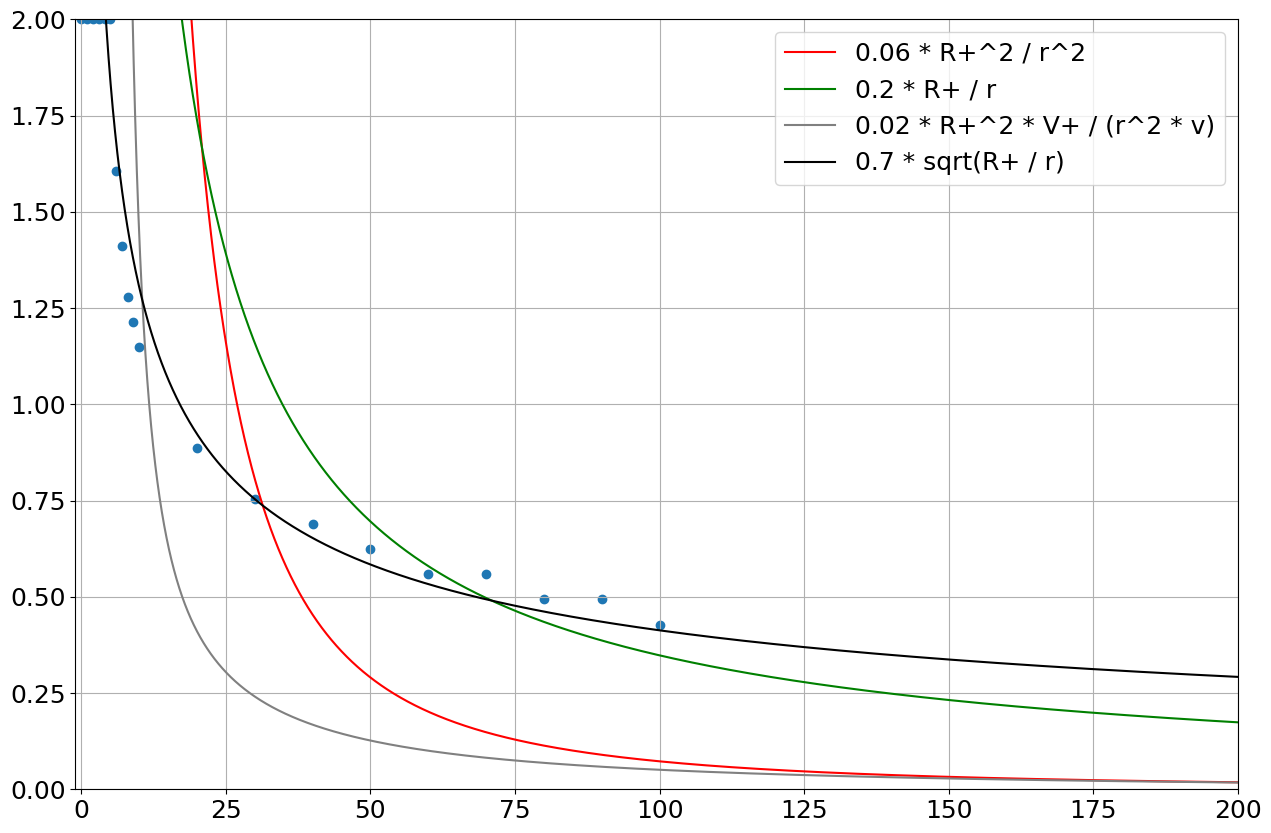

In [132]:
plt.scatter(rs[IS_COARSE] / 1000, LBDAS_COARSE, c='tab:blue')
plt.scatter(rs[IS] / 1000, LBDAS, c='tab:blue')
plt.plot(rs / 1000, 0.6 * Rp_ini ** 2 / (rs ** 2), c='r', label='0.06 * R+^2 / r^2')
plt.plot(rs / 1000, 1 * (Rp_ini / rs) ** 1, c='g', label='0.2 * R+ / r')
plt.plot(rs / 1000, 0.2 * (Rp_ini ** 2 * Vp_ini / (rs ** 2 * Vh_ini)), c='gray', label='0.02 * R+^2 * V+ / (r^2 * v)')
plt.plot(rs / 1000, 0.7 * (Rp_ini / rs) ** 0.5, c='k', label='0.7 * sqrt(R+ / r)')
plt.xlim(-1, 200)
plt.ylim(0, 2)
plt.grid();plt.legend()

In [136]:
np.log(10)

2.302585092994046